In [1]:
from torchsr.datasets import Div2K
from torchsr.models import ninasr_b0
from torchvision.transforms.functional import to_pil_image, to_tensor
from torch.utils.data import Dataset
from torch import nn
import torch
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Div2K dataset
dataset = Div2K(root="./data", scale=2, download=False)

In [2]:
hr, lr = dataset[0]

In [3]:
class ImageDataset(Dataset):
    def __init__(self, coordinates, pixel_values):
        self.coordinates = coordinates.astype(np.float32)
        self.pixel_values = pixel_values.astype(np.float32)
    
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        coord = self.coordinates[idx]
        pixel = self.pixel_values[idx]
        return coord, pixel
    
class INRModel(nn.Module):
    def __init__(self, input_dim=2, output_dim=3, hidden_dim=256, num_layers=4, dropout_rate=0.5):
        super().__init__()
        
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Ensure output is in [0, 1] range since the rgb values are normalized
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)
    
    def train_model(self, dataloader, num_epochs = 100, lr = 1e-3, device = 'cpu' if not torch.cuda.is_available() else 'cuda', criterion = nn.MSELoss(), optimizer = None):
        if optimizer is None:
            optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.train()
        self.to(device)
        
        losses = []
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0
            
            for batch_coords, batch_pixels in dataloader:
                batch_coords = batch_coords.to(device)
                batch_pixels = batch_pixels.to(device)
                
                # Forward pass
                pred_pixels = self(batch_coords)
                
                # Compute loss
                loss = criterion(pred_pixels, batch_pixels)
                total_loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
        
        return losses
    
class Sine(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        
    def forward(self, x):
        return torch.sin(self.omega_0 * x)

class BabySINE(nn.Module):
    def __init__(self, 
                 input_dim=2, 
                 output_dim=3,
                 hidden_dim=256,
                 num_layers=4,
                 omega_0=30,
                 sigma=10.0,
                 use_dropout=False,
                 dropout_rate=0.1):
        super().__init__()
        self.sigma = sigma
        self.omega_0 = omega_0
        
        layers = []
        # Input layer with sine activation
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(Sine(omega_0))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(Sine())
            if use_dropout:
                layers.append(nn.Dropout(dropout_rate))
        
        # Final output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Keep output in [0,1] for RGB
        
        self.network = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        """SIREN-style weight initialization"""
        with torch.no_grad():
            for idx, layer in enumerate(self.network):
                if isinstance(layer, nn.Linear):
                    # Calculate fan_in
                    fan_in = layer.weight.size(1)
                    
                    # First layer initialization
                    if idx == 0:  # First linear layer
                        bound = 1 / fan_in
                    else:
                        bound = torch.sqrt(torch.tensor(6.0 / fan_in)) / self.omega_0
                        
                    # Uniform initialization
                    nn.init.uniform_(layer.weight, -bound, bound)
                    nn.init.zeros_(layer.bias)

    def forward(self, x, sigma=None):
        """Forward pass with optional sigma scaling"""
        if sigma is None:
            sigma = self.sigma
        # Scale input coordinates by sigma
        x = x * sigma
        return self.network(x)

    def train_model(self, 
               dataloader, 
               num_epochs=100, 
               lr=1e-3, 
               device='cuda' if torch.cuda.is_available() else 'cpu',
               criterion=nn.MSELoss(),
               optimizer=None,
               sigma=10.0,
               sigma_growth=1.0):  # Renamed from sigma_decay for clarity
        """
        Train model with progressive sigma scaling
        Args:
            sigma_growth: Multiplicative factor for sigma per epoch (1.0 = no growth)
        """
        # Validate parameters
        if sigma_growth <= 0:
            raise ValueError("sigma_growth must be > 0")
        
        # Initialize optimizer
        if optimizer is None:
            optimizer = optim.AdamW(self.parameters(), lr=lr)
        
        # Training setup
        self.train()
        self.to(device)
        current_sigma = sigma
        sigma_history = []
        losses = []

        # Training loop
        for epoch in tqdm(range(num_epochs)):
            epoch_loss = 0
            
            # Update sigma (before epoch for consistent progress)
            current_sigma *= sigma_growth
            sigma_history.append(current_sigma)

            for batch_coords, batch_pixels in dataloader:
                # Move data to device
                batch_coords = batch_coords.to(device)
                batch_pixels = batch_pixels.to(device)
                
                # Forward pass with current sigma
                pred_pixels = self(batch_coords, current_sigma)
                
                # Calculate loss
                loss = criterion(pred_pixels, batch_pixels)
                epoch_loss += loss.item()
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Store metrics
            avg_loss = epoch_loss / len(dataloader)
            losses.append(avg_loss)
            
            # Progress reporting
            if epoch % 10 == 0:
                print(f"Epoch {epoch} | Loss: {avg_loss:.6f} | Sigma: {current_sigma:.2f}")

        return losses, sigma_history

In [4]:
def plot_image(image, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Original Image: {title}")
    plt.show()

    # Get image dimensions
    height_target, width_target, channels = image.shape
    print(f"Image dimensions: {height_target}x{width_target}, {channels} channels")


def pixel_coordinates_normalized(image, downsize_factor): 
    print(image.shape[0])
    x, y = image.shape[:2]
    resized_image = cv.resize(image, (y // downsize_factor, x // downsize_factor))
    resized_x, resized_y = resized_image.shape[:2]
    xs = np.linspace(0, 1, resized_x)  # x coordinates (0 to 1)
    ys = np.linspace(0, 1, resized_y)  # y coordinates (0 to 1)

    xx, yy = np.meshgrid(xs, ys, indexing="ij")
    coordinates = np.stack((xx, yy), axis=-1)
    coordinates = coordinates.reshape(-1, 2) 
    resized_image = resized_image/255.0
    norm_resized_image = (resized_image - np.mean(resized_image)) / np.std(resized_image)
    pixel_values = norm_resized_image.reshape(-1, 3)
    
    return coordinates, pixel_values, norm_resized_image, resized_x, resized_y



In [5]:
image = np.array(hr)

#plot_image(image)
coordinates, pixel_values, norm_image, x, y = pixel_coordinates_normalized(image, 10)
downsize_factor = 3
print(f"Downsize factor: {downsize_factor}")

1404
Downsize factor: 3


In [6]:
# Create dataset and dataloader
dataset = ImageDataset(coordinates, pixel_values)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)


In [7]:
# # Create and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.MSELoss()
channels = 3

# model = INRModel(input_dim=2, output_dim=channels, hidden_dim=128, num_layers=3, dropout_rate=0.5)


# # Plot the loss curve
# plt.figure(figsize=(10, 4))
# plt.plot(losses)
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.grid(True)
# plt.show()

  0%|          | 1/300 [00:00<02:49,  1.76it/s]

Epoch 0 | Loss: 1.245645 | Sigma: 15.00


  4%|▎         | 11/300 [00:05<02:29,  1.93it/s]

Epoch 10 | Loss: 0.840562 | Sigma: 15.00


  7%|▋         | 21/300 [00:11<03:08,  1.48it/s]

Epoch 20 | Loss: 0.623028 | Sigma: 15.00


 10%|█         | 31/300 [00:19<03:27,  1.30it/s]

Epoch 30 | Loss: 0.587298 | Sigma: 15.00


 14%|█▎        | 41/300 [00:27<03:28,  1.24it/s]

Epoch 40 | Loss: 0.570525 | Sigma: 15.00


 17%|█▋        | 51/300 [00:35<03:18,  1.25it/s]

Epoch 50 | Loss: 0.559162 | Sigma: 15.00


 20%|██        | 61/300 [00:43<03:21,  1.19it/s]

Epoch 60 | Loss: 0.551052 | Sigma: 15.00


 24%|██▎       | 71/300 [00:51<03:06,  1.23it/s]

Epoch 70 | Loss: 0.545243 | Sigma: 15.00


 27%|██▋       | 81/300 [00:59<02:52,  1.27it/s]

Epoch 80 | Loss: 0.540983 | Sigma: 15.00


 30%|███       | 91/300 [01:07<02:52,  1.21it/s]

Epoch 90 | Loss: 0.537961 | Sigma: 15.00


 34%|███▎      | 101/300 [01:16<02:43,  1.21it/s]

Epoch 100 | Loss: 0.535299 | Sigma: 15.00


 37%|███▋      | 111/300 [01:24<02:34,  1.23it/s]

Epoch 110 | Loss: 0.533494 | Sigma: 15.00


 40%|████      | 121/300 [01:32<02:21,  1.27it/s]

Epoch 120 | Loss: 0.532117 | Sigma: 15.00


 44%|████▎     | 131/300 [01:40<02:23,  1.17it/s]

Epoch 130 | Loss: 0.530894 | Sigma: 15.00


 47%|████▋     | 141/300 [01:48<02:07,  1.25it/s]

Epoch 140 | Loss: 0.530012 | Sigma: 15.00


 50%|█████     | 151/300 [01:56<01:59,  1.25it/s]

Epoch 150 | Loss: 0.529047 | Sigma: 15.00


 54%|█████▎    | 161/300 [02:04<01:50,  1.26it/s]

Epoch 160 | Loss: 0.528590 | Sigma: 15.00


 57%|█████▋    | 171/300 [02:12<01:45,  1.22it/s]

Epoch 170 | Loss: 0.527924 | Sigma: 15.00


 60%|██████    | 181/300 [02:20<01:37,  1.23it/s]

Epoch 180 | Loss: 0.527491 | Sigma: 15.00


 64%|██████▎   | 191/300 [02:29<01:27,  1.24it/s]

Epoch 190 | Loss: 0.527029 | Sigma: 15.00


 67%|██████▋   | 201/300 [02:37<01:21,  1.22it/s]

Epoch 200 | Loss: 0.526595 | Sigma: 15.00


 70%|███████   | 211/300 [02:45<01:10,  1.27it/s]

Epoch 210 | Loss: 0.526269 | Sigma: 15.00


 74%|███████▎  | 221/300 [02:53<01:04,  1.22it/s]

Epoch 220 | Loss: 0.526027 | Sigma: 15.00


 77%|███████▋  | 231/300 [03:01<00:55,  1.25it/s]

Epoch 230 | Loss: 0.525861 | Sigma: 15.00


 80%|████████  | 241/300 [03:09<00:48,  1.21it/s]

Epoch 240 | Loss: 0.525544 | Sigma: 15.00


 84%|████████▎ | 251/300 [03:17<00:38,  1.26it/s]

Epoch 250 | Loss: 0.525161 | Sigma: 15.00


 87%|████████▋ | 261/300 [03:25<00:31,  1.22it/s]

Epoch 260 | Loss: 0.524914 | Sigma: 15.00


 90%|█████████ | 271/300 [03:34<00:24,  1.20it/s]

Epoch 270 | Loss: 0.524811 | Sigma: 15.00


 94%|█████████▎| 281/300 [03:42<00:15,  1.25it/s]

Epoch 280 | Loss: 0.524682 | Sigma: 15.00


 97%|█████████▋| 291/300 [03:50<00:07,  1.24it/s]

Epoch 290 | Loss: 0.524421 | Sigma: 15.00


100%|██████████| 300/300 [03:57<00:00,  1.26it/s]


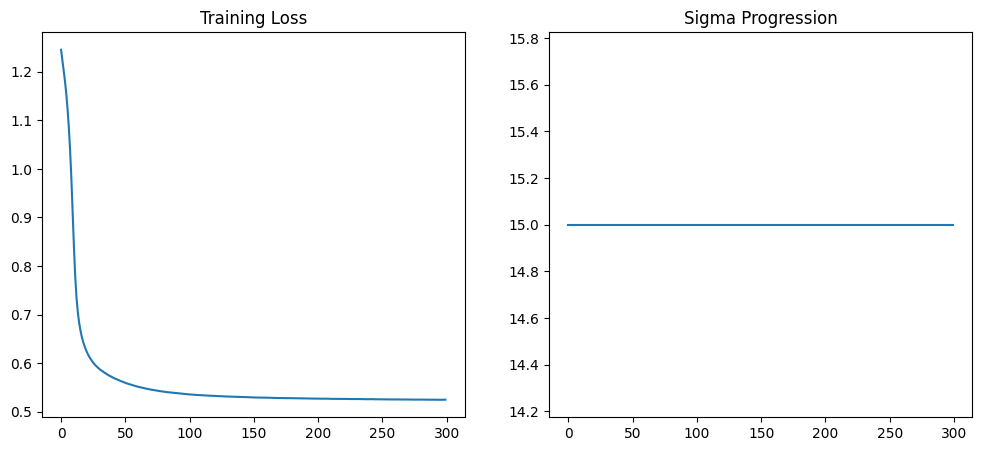

In [8]:
# Progressive frequency training
model = BabySINE(sigma=10.0, omega_0=15)
losses, sigmas = model.train_model(
    dataloader,
    num_epochs=300,
    lr=1e-4,
    sigma=15.0,  # Starting low frequency
    sigma_growth=1 # 2% increase per epoch
)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(sigmas)
plt.title('Sigma Progression')
plt.show()

Max and Min values of pred_pixels: 0.9999494552612305, 5.32770536665339e-05


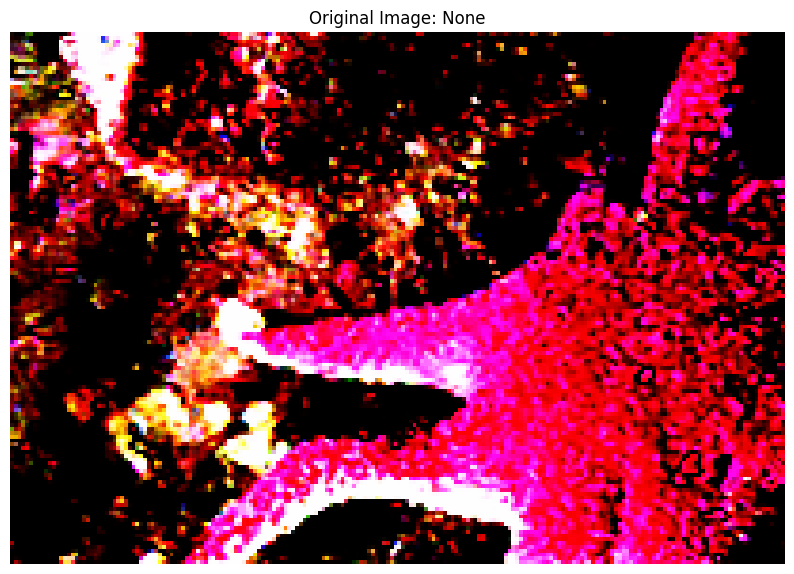

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image dimensions: 140x204, 3 channels


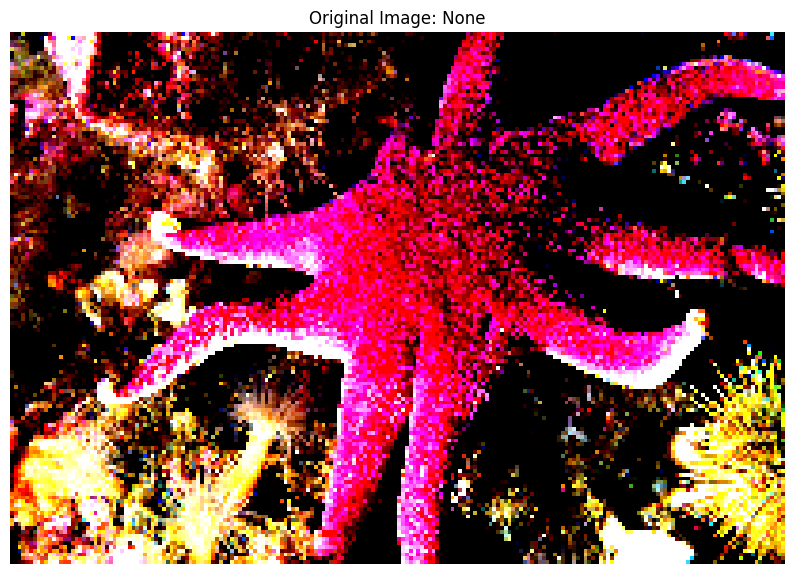

Image dimensions: 140x204, 3 channels
Downsized image shape: (140, 204, 3)
Reconstructed image shape: (140, 204, 3)
Original image shape: (140, 204, 3)


In [9]:
target_coords_tensor = torch.from_numpy(coordinates).float().to(device)

# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = model(target_coords_tensor).cpu().numpy()
    
print(f"Max and Min values of pred_pixels: {np.max(pred_pixels)}, {np.min(pred_pixels)}")

reconstructed_img_reshaped_normalized = pred_pixels.reshape(x, y, channels)
reconstructed_img_reshaped_denormalized = (reconstructed_img_reshaped_normalized * 255).astype(np.uint8)
reconstructed_img_reshaped_denormalized = np.clip(reconstructed_img_reshaped_denormalized, 0, 255)
plot_image(reconstructed_img_reshaped_denormalized)
plot_image(norm_image)
# Check that the shapes of the reconstructed image and original image are the same

print(f"Downsized image shape: {norm_image.shape}")
print(f"Reconstructed image shape: {reconstructed_img_reshaped_denormalized.shape}")
print(f"Original image shape: {norm_image.shape}")

Max and Min values of pred_pixels: 0.9999494552612305, 5.32770536665339e-05


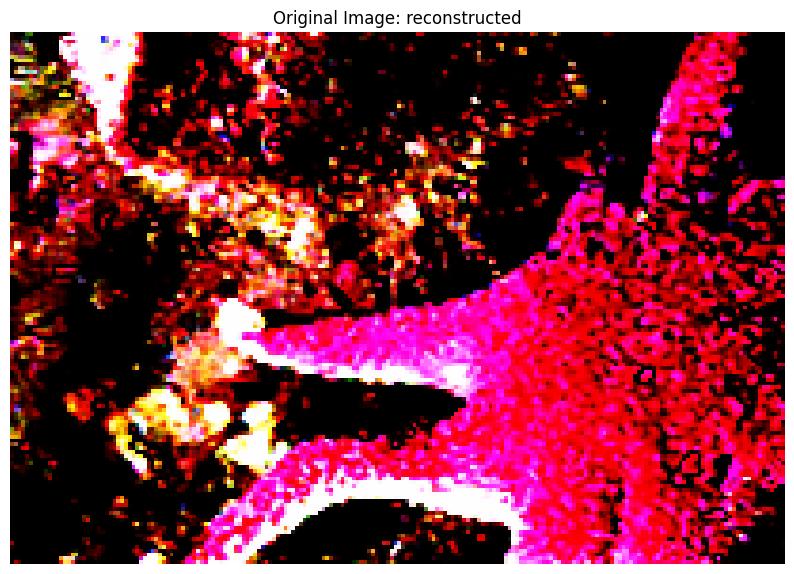

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image dimensions: 140x204, 3 channels


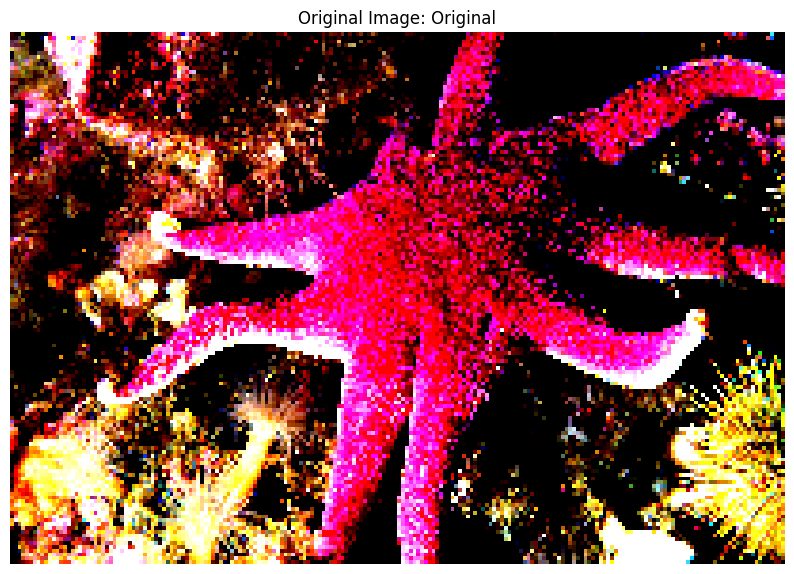

Image dimensions: 140x204, 3 channels
Downsized image shape: (140, 204, 3)
Reconstructed image shape: (140, 204, 3)
Original image shape: (140, 204, 3)


In [11]:
target_coords_tensor = torch.from_numpy(coordinates).float().to(device)

# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = model(target_coords_tensor).cpu().numpy()
    
print(f"Max and Min values of pred_pixels: {np.max(pred_pixels)}, {np.min(pred_pixels)}")

reconstructed_img_reshaped_normalized = pred_pixels.reshape(x, y, channels)
reconstructed_img_reshaped_denormalized = (reconstructed_img_reshaped_normalized * 255).astype(np.uint8)
reconstructed_img_reshaped_denormalized = np.clip(reconstructed_img_reshaped_denormalized, 0, 255)
plot_image(reconstructed_img_reshaped_denormalized, "reconstructed")
plot_image(norm_image, "Original")
# Check that the shapes of the reconstructed image and original image are the same

print(f"Downsized image shape: {norm_image.shape}")
print(f"Reconstructed image shape: {reconstructed_img_reshaped_denormalized.shape}")
print(f"Original image shape: {norm_image.shape}")